## Example Notebook: Epoch-Wise Post-Hoc Reversal on CIFAR-N

This notebook reproduces the epoch-wise post-hoc reversal curves for CIFAR-N (Figure 1 in the paper), modulo styling.

Other datasets are similar, except that they don't have the `--noise` argument (they are naturally noisy).

### Experimental Runs

#### Setup

In [18]:
import os

import matplotlib.pyplot as plt
import pandas as pd

from expt.utils import KeyValStore

# "cifar10", "cifar100_coarse", or "cifar100_fine"
os.environ["DATASET"] = "cifar10"

# "clean", "aggregate", "random1", "random2", "random3", or "worst" for cifar10
# "clean" or "noisy" for cifar100_coarse and cifar100_fine
os.environ["NOISE"] = "worst"

# number of models to train for ensembling
os.environ["ENSEMBLE_SIZE"] = "8"

# name of wandb project
# use "" to skip wandb logging
os.environ["WANDB"] = "post-hoc-reversal"

Running for the first time downloads and prepares the data.

In [2]:
%%bash
python -m expt.cifar --root out/dummy --wandb '' --dataset $DATASET --noise $NOISE --num-epochs 0

args=Namespace(root='out/dummy', wandb='', dataset='cifar10', noise='worst', eval_batch_size=1000, train_batch_size=500, model='resnet18d', pretrained=True, width=64, optimizer='sgd', lr=0.1, momentum=0.9, weight_decay=0.0005, scheduler='cosine', num_epochs=0, amp=True, loss='ce', sop_lr_u=10.0, sop_lr_v=100.0, elr_momentum=0.9, elr_weight=1.0)
num_classes=10
len(X['train'])=40000
len(X['val'])=5000
len(X['test'])=5000
max class freq: 0.12105999886989594
min class freq: 0.08079999685287476


#### Base (no transform) and SWA

Train `$ENSEMBLE_SIZE` models in parallel with default hyperparameters.  
Use `python -m expt.cifar --help` for options.

This assumes `$ENSEMBLE_SIZE` GPUs are available.  
For CPU-only environments, use `export CUDA_VISIBLE_DEVICES=''`.  
For single-GPU environments, use `export CUDA_VISIBLE_DEVICES=0`.  
For sequential execution, e.g. to prevent memory issues on a single GPU, remove the `&`.

On a _Quadro RTX 8000_ GPU, each run takes around 3 minutes.

This records the Base (no transform) and SWA checkpoints for every epoch.

In [3]:
%%bash
for i in $(seq 1 $ENSEMBLE_SIZE)
do
    export CUDA_VISIBLE_DEVICES=$i
    python -m expt.cifar --root out/idv$i --wandb $WANDB --dataset $DATASET --noise $NOISE &
done
wait

args=Namespace(root='out/idv1', wandb='post-hoc-reversal', dataset='cifar10', noise='worst', eval_batch_size=1000, train_batch_size=500, model='resnet18d', pretrained=True, width=64, optimizer='sgd', lr=0.1, momentum=0.9, weight_decay=0.0005, scheduler='cosine', num_epochs=100, amp=True, loss='ce', sop_lr_u=10.0, sop_lr_v=100.0, elr_momentum=0.9, elr_weight=1.0)
num_classes=10
len(X['train'])=40000
len(X['val'])=5000
len(X['test'])=5000
max class freq: 0.12105999886989594
min class freq: 0.08079999685287476
run.name='cifar10__worst__idv1'
args=Namespace(root='out/idv3', wandb='post-hoc-reversal', dataset='cifar10', noise='worst', eval_batch_size=1000, train_batch_size=500, model='resnet18d', pretrained=True, width=64, optimizer='sgd', lr=0.1, momentum=0.9, weight_decay=0.0005, scheduler='cosine', num_epochs=100, amp=True, loss='ce', sop_lr_u=10.0, sop_lr_v=100.0, elr_momentum=0.9, elr_weight=1.0)
num_classes=10
len(X['train'])=40000
len(X['val'])=5000
len(X['test'])=5000
max class freq

#### Temperature Scaling

Now we calibrate (temperature-scale) the Base and SWA checkpoints for every epoch. On a _Quadro RTX 8000_ GPU this takes around 20s.

In [4]:
%%bash
for i in $(seq 1 $ENSEMBLE_SIZE)
do
    export CUDA_VISIBLE_DEVICES=$i
    python -m expt.calibrate --root out/idv$i --wandb $WANDB --base base &
    python -m expt.calibrate --root out/idv$i --wandb $WANDB --base base+swa &
done
wait

args=Namespace(root='out/idv1', wandb='post-hoc-reversal', base='base+swa', cal='temp_scaler', suf='ts')
args=Namespace(root='out/idv2', wandb='post-hoc-reversal', base='base+swa', cal='temp_scaler', suf='ts')
args=Namespace(root='out/idv2', wandb='post-hoc-reversal', base='base', cal='temp_scaler', suf='ts')
args=Namespace(root='out/idv1', wandb='post-hoc-reversal', base='base', cal='temp_scaler', suf='ts')
args=Namespace(root='out/idv4', wandb='post-hoc-reversal', base='base', cal='temp_scaler', suf='ts')
args=Namespace(root='out/idv4', wandb='post-hoc-reversal', base='base+swa', cal='temp_scaler', suf='ts')
args=Namespace(root='out/idv3', wandb='post-hoc-reversal', base='base', cal='temp_scaler', suf='ts')
args=Namespace(root='out/idv3', wandb='post-hoc-reversal', base='base+swa', cal='temp_scaler', suf='ts')


#### Ensembling

Next, we ensemble the base models and all compositions of post-hoc transforms we have so far, per epoch. On a _Quadro RTX 8000_ GPU this takes around 20s. Note that _"ensemble"_ in the paper actually refers to `ts+ens` in the code.

In [5]:
%%bash
for s in val test
do
    for b in base base+swa base+ts base+swa+ts
    do
        python -m expt.ensemble --root out/ens$ENSEMBLE_SIZE --wandb $WANDB --runs out/idv* --split $s --base $b &
    done
done
wait

args=Namespace(root='out/ens4', wandb='post-hoc-reversal', runs=['out/idv1', 'out/idv2', 'out/idv3', 'out/idv4'], split='test', base='base+swa+ts')
args=Namespace(root='out/ens4', wandb='post-hoc-reversal', runs=['out/idv1', 'out/idv2', 'out/idv3', 'out/idv4'], split='test', base='base+ts')
args=Namespace(root='out/ens4', wandb='post-hoc-reversal', runs=['out/idv1', 'out/idv2', 'out/idv3', 'out/idv4'], split='val', base='base+ts')
args=Namespace(root='out/ens4', wandb='post-hoc-reversal', runs=['out/idv1', 'out/idv2', 'out/idv3', 'out/idv4'], split='val', base='base')
args=Namespace(root='out/ens4', wandb='post-hoc-reversal', runs=['out/idv1', 'out/idv2', 'out/idv3', 'out/idv4'], split='test', base='base')
args=Namespace(root='out/ens4', wandb='post-hoc-reversal', runs=['out/idv1', 'out/idv2', 'out/idv3', 'out/idv4'], split='test', base='base+swa')
args=Namespace(root='out/ens4', wandb='post-hoc-reversal', runs=['out/idv1', 'out/idv2', 'out/idv3', 'out/idv4'], split='val', base='base+s

Finally, we calibrate the ensembles (again, for every epoch). On a _Quadro RTX 8000_ GPU this takes around 20s.

In [6]:
%%bash
for b in base+ens base+swa+ens base+ts+ens base+swa+ts+ens
do
    python -m expt.calibrate --root out/ens$ENSEMBLE_SIZE --wandb $WANDB --base $b &
done
wait

args=Namespace(root='out/ens4', wandb='post-hoc-reversal', base='base+ens', cal='temp_scaler', suf='ts')
args=Namespace(root='out/ens4', wandb='post-hoc-reversal', base='base+swa+ens', cal='temp_scaler', suf='ts')
args=Namespace(root='out/ens4', wandb='post-hoc-reversal', base='base+ts+ens', cal='temp_scaler', suf='ts')
args=Namespace(root='out/ens4', wandb='post-hoc-reversal', base='base+swa+ts+ens', cal='temp_scaler', suf='ts')


### Plots for Post-Hoc Reversal

In [10]:
def draw(ax, kv, metric, ts=False):
    scale = 100 if metric == "err" else 1
    suf = "+ts" if ts else ""

    x = kv.load("epochs")

    Y = kv.load(f"{metric}/test/base{suf}") * scale
    for y in Y:
        ax.plot(x, y, color="tab:blue", alpha=0.2)
    y = Y.mean(0)
    ax.plot(x, y, color="tab:blue", label="Base individual")

    Y = kv.load(f"{metric}/test/base+swa{suf}") * scale
    for y in Y:
        ax.plot(x, y, color="tab:orange", alpha=0.2)
    y = Y.mean(0)
    ax.plot(x, y, color="tab:orange", label="SWA individual")

    y = kv.load(f"{metric}/test/base+ts+ens{suf}") * scale
    ax.plot(x, y, ls="--", color="tab:blue", label="Base ensemble")

    y = kv.load(f"{metric}/test/base+swa+ts+ens{suf}") * scale
    ax.plot(x, y, ls="--", color="tab:orange", label="SWA ensemble")

    ax.legend()

    ax.set_xlabel("Epochs")
    if metric == "err":
        ax.set_ylabel("Test Error (%)")
    elif metric == "nll":
        if ts:
            ax.set_ylabel("Test Loss (post-TS)")
        else:
            ax.set_ylabel("Test Loss (pre-TS)")

In [11]:
kv = KeyValStore(f"out/ens{os.environ['ENSEMBLE_SIZE']}")

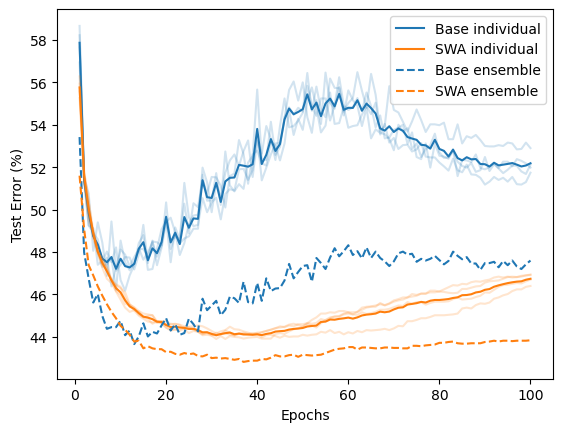

In [12]:
fig, ax = plt.subplots()
draw(ax, kv, "err")
fig.show()

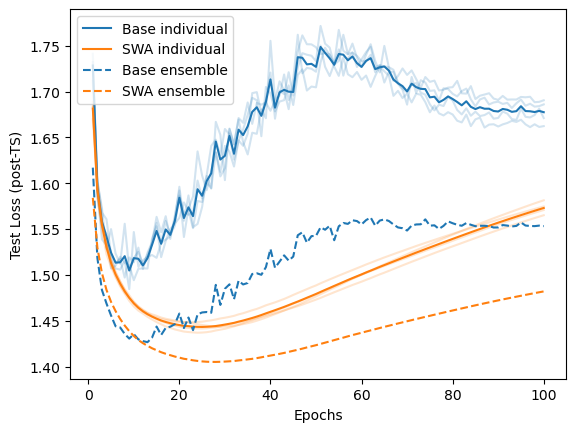

In [13]:
fig, ax = plt.subplots()
draw(ax, kv, "nll", ts=True)
fig.show()

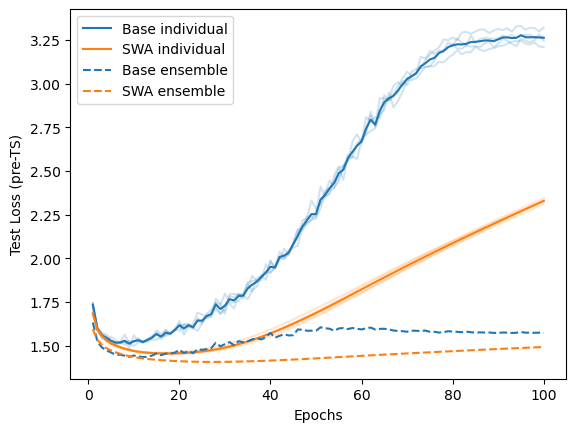

In [14]:
fig, ax = plt.subplots()
draw(ax, kv, "nll", ts=False)
fig.show()

### Table for Post-Hoc Selection

In [15]:
%%bash
python -m expt.select --root out/ens$ENSEMBLE_SIZE

args=Namespace(root='out/ens4', bases=['base', 'base+swa', 'base+ts', 'base+swa+ts', 'base+ens', 'base+swa+ens', 'base+ts+ens', 'base+swa+ts+ens', 'base+ens+ts', 'base+swa+ens+ts', 'base+ts+ens+ts', 'base+swa+ts+ens+ts'])


In [9]:
kv = KeyValStore(f"out/ens{os.environ['ENSEMBLE_SIZE']}")

Here we reproduce the post-hoc selection vs naive selection results from Table 1 in the paper. When possible, we show mean +- std.

In [14]:
txt = {
    "nll": "Test Loss",
    "err": "Test Error (%)",
    "base": "No Transform",
    "base+swa+ts": "SWA+TS",
    "base+swa+ts+ens+ts": "SWA+Ens+TS",
    "pre": "Naive",
    "post": "Ours",
}

In [21]:
rec = {}
for metric in ["nll", "err"]:
    scale = 100 if metric == "err" else 1
    fmt = ".2f" if metric == "err" else ".3f"

    for tr in ["base", "base+swa+ts", "base+swa+ts+ens+ts"]:
        for sel in ["pre", "post"]:
            key = (txt[metric], txt[tr], txt[sel])
            kv_key = f"sel={sel}/obj={metric}/{metric}/test/{tr}"
            kv_val = kv.load(kv_key).float() * scale
            if "ens" in tr:
                val = f"{kv_val.item():{fmt}}"
            else:
                val = f"{kv_val.mean().item():{fmt}}$\\pm${kv_val.std().item():{fmt}}"
            rec[key] = [val]
pd.DataFrame(rec)

Test Loss                                                     \
      No Transform                            SWA+TS                    
             Naive             Ours            Naive             Ours   
0  1.508$\pm$0.015  1.508$\pm$0.015  1.489$\pm$0.012  1.445$\pm$0.006   

                     Test Error (%)                                  \
  SWA+Ens+TS           No Transform                          SWA+TS   
       Naive   Ours           Naive            Ours           Naive   
0      1.450  1.407  46.98$\pm$0.80  46.98$\pm$0.80  46.46$\pm$0.88   

                                     
                  SWA+Ens+TS         
             Ours      Naive   Ours  
0  44.15$\pm$0.15      44.98  43.16